# Neural Net, Deep Learning Model Experimentation
Exporing neural networks and deep learning architectures such as Transformers. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings

# Torch required packages
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Load data

In [2]:
south_central_wz = pq.read_table(f"data/south_central_wz.parquet").to_pandas()

In [3]:
lim = south_central_wz[[
    'YEAR', 'MONTH', 'DAY', 'HOUR_ENDING', 
    'SOUTH_C',
    'DRY_BULB_TEMPERATURE_KAUS', 
    'RELATIVE_HUMIDITY_KAUS', 
    'DRY_BULB_TEMPERATURE_KSAT', 
    'RELATIVE_HUMIDITY_KSAT',
]]
for str_issue_col in [
    'DRY_BULB_TEMPERATURE_KAUS', 
    'RELATIVE_HUMIDITY_KAUS', 
    'DRY_BULB_TEMPERATURE_KSAT', 
    'RELATIVE_HUMIDITY_KSAT'
]:
    with pd.option_context('mode.chained_assignment', None):
        lim[str_issue_col] = [_.replace('s', '') if isinstance(_, str) else _ for _ in lim[str_issue_col]]
        lim.loc[lim[str_issue_col] == '*', str_issue_col] = None
        lim[str_issue_col] = lim[str_issue_col].astype('float')

In [4]:
lim.isna().sum()

YEAR                             0
MONTH                            0
DAY                              0
HOUR_ENDING                      0
SOUTH_C                      52512
DRY_BULB_TEMPERATURE_KAUS        4
RELATIVE_HUMIDITY_KAUS          11
DRY_BULB_TEMPERATURE_KSAT        3
RELATIVE_HUMIDITY_KSAT           6
dtype: int64

In [5]:
lim_datetime = lim.copy()
lim_datetime['DATETIME'] = [
    datetime(int(row['YEAR']), int(row['MONTH']), int(row['DAY']), int(row['HOUR_ENDING'] - 1))  # hour cannot be 24 
    for i, row in lim_datetime.iterrows()
]
lim_datetime = lim_datetime[[_ for _ in lim_datetime.columns if _ not in ['YEAR', 'MONTH', 'DAY', 'HOUR_ENDING']]]
lim_datetime.dropna(how='any', inplace=True)

Text(0.5, 1.0, 'Load')

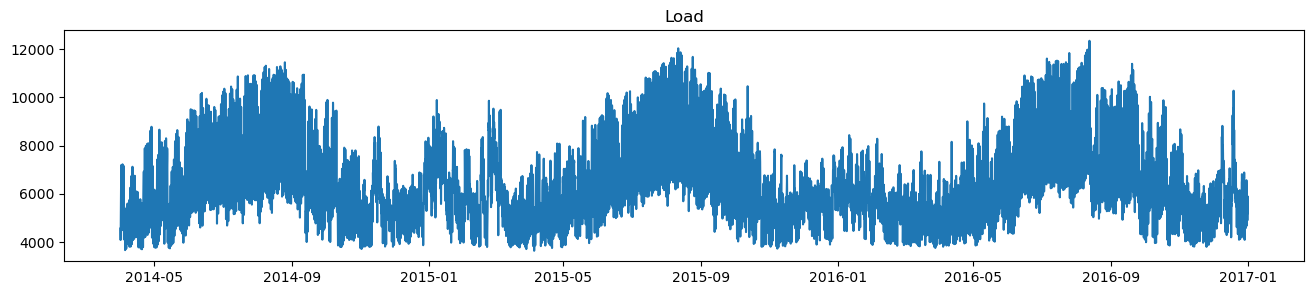

In [6]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['SOUTH_C'])
ax.set_title(label='Load')

Text(0.5, 1.0, 'Temperature')

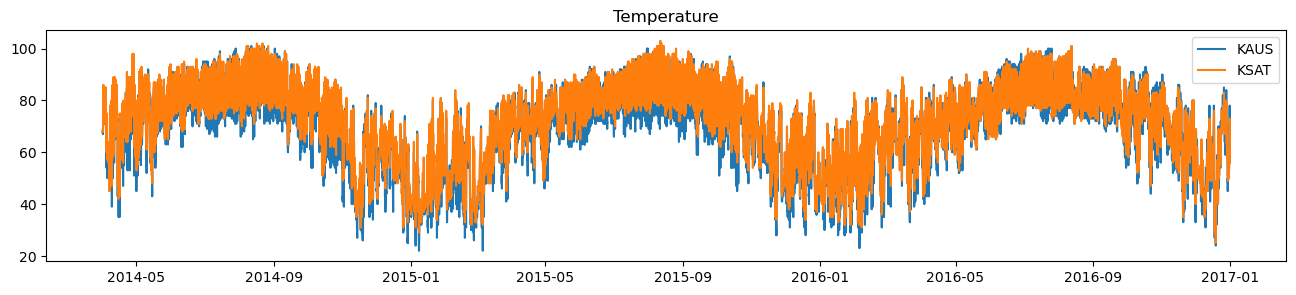

In [7]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['DRY_BULB_TEMPERATURE_KAUS'], label='KAUS')
ax.plot(lim_datetime['DATETIME'], lim_datetime['DRY_BULB_TEMPERATURE_KSAT'], label='KSAT')
ax.legend()
ax.set_title(label='Temperature')

Text(0.5, 1.0, 'Relative Humidity')

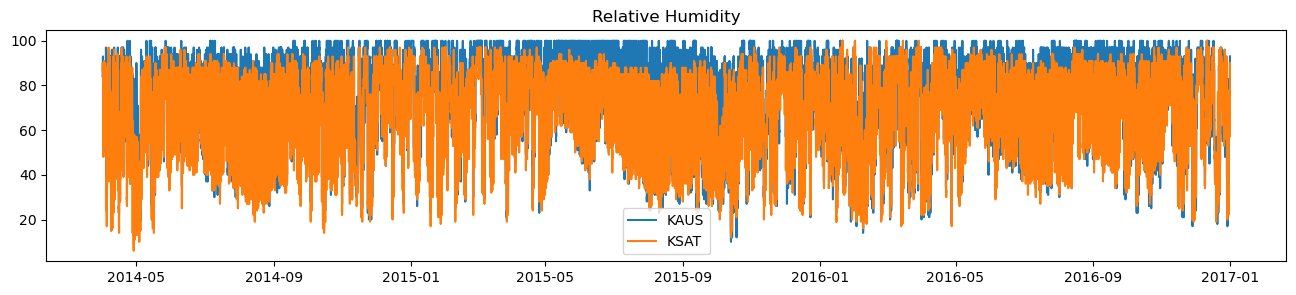

In [8]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(lim_datetime['DATETIME'], lim_datetime['RELATIVE_HUMIDITY_KAUS'], label='KAUS')
ax.plot(lim_datetime['DATETIME'], lim_datetime['RELATIVE_HUMIDITY_KSAT'], label='KSAT')
ax.legend()
ax.set_title(label='Relative Humidity')

In [9]:
# TODO: check data load process to see if this limiation can be avoided
lim = lim.dropna(how='any')
with pd.option_context('mode.chained_assignment', None):
    datetime_ref = [
        datetime(int(row['YEAR']), int(row['MONTH']), int(row['DAY']), int(row['HOUR_ENDING'] - 1))  # hour cannot be 24 
        for i, row in lim.iterrows()
    ]

In [13]:
cols = lim.columns.tolist()
features = cols[0:4] + cols[5:]

X = lim[features]
y = lim[["SOUTH_C"]]

In [14]:
features

['YEAR',
 'MONTH',
 'DAY',
 'HOUR_ENDING',
 'DRY_BULB_TEMPERATURE_KAUS',
 'RELATIVE_HUMIDITY_KAUS',
 'DRY_BULB_TEMPERATURE_KSAT',
 'RELATIVE_HUMIDITY_KSAT']

In [15]:
train_X, test_X, train_y, test_y = train_test_split(
    X,
    y,
    test_size = 0.1
)

In [50]:
class TimeSeriesDataset(Dataset):
    def __init__(self, raw_data, raw_label, training_length, forecast_window):
        
        df = raw_data.copy()
        df["SOUTH_C"] = raw_label
        
        self.df = df
        self.T = training_length
        self.S = forecast_window
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        training_items = self.df[[
            # 'DRY_BULB_TEMPERATURE_KAUS',
            # 'RELATIVE_HUMIDITY_KAUS',
            # 'DRY_BULB_TEMPERATURE_KSAT',
            # 'RELATIVE_HUMIDITY_KSAT',
            'SOUTH_C',
            'YEAR', 'MONTH', 'DAY', 'HOUR_ENDING', 
            'DRY_BULB_TEMPERATURE_KAUS', 
            'RELATIVE_HUMIDITY_KAUS', 
            'DRY_BULB_TEMPERATURE_KSAT', 
            'RELATIVE_HUMIDITY_KSAT',
        ]]
        
        testing_items = self.df[["SOUTH_C"]]
        
        _input = training_items[idx : idx + self.T].values
        target = testing_items[idx + self.T : idx + self.T + self.S].values
        return _input, target

In [51]:
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=5,num_layers=3,dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src))
        output = self.transformer_encoder(src, mask = mask)
        output = self.decoder(output)
        return output

In [52]:
training_length = 24 # In Hours
forecast_window = 24 # In Hours

train_dataset = TimeSeriesDataset(train_X, train_y, training_length, forecast_window)
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = False)

test_dataset = TimeSeriesDataset(test_X, test_y, training_length, forecast_window)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [59]:
EPOCH = 1
FEATURES = 9
NUM_LAYERS = 3
DROPOUT = 0.0
LR = 1e-4

model = Transformer(
    feature_size = FEATURES, 
    num_layers = NUM_LAYERS,
    dropout = DROPOUT
).double()

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.MSELoss()

In [60]:
for epoch in range(EPOCH):
    epoch_loss = 0.0
    for batch, (_input, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        src = _input.double()
        target = _input.double()
        
        prediction = model(src)
        loss = criterion(prediction, target[:,:,-1].unsqueeze(-1))
        # loss = torch.sqrt(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()  # running loss?
        # epoch_loss += np.sqrt(loss.detach().item())  # adding sqrt to running loss? 
        # epoch_loss_rmse = np.sqrt(epoch_loss)
        if (batch + 1) % 500 == 0:
            # print("Batch %5d / %5d: RMSE loss %4.4f" % (batch, len(train_dataloader), epoch_loss_rmse))
            print(f"Batch: {batch + 1} / {len(train_dataloader)}, RMSE Loss: {epoch_loss / (batch + 1):.3f}")
    # print("Epoch %2d: RMSE loss %4.4f" % (epoch, epoch_loss / ()))
    print(f"Epoch: {epoch + 1} / {EPOCH}, RMSE Loss: {epoch_loss / (batch + 1):.3f}")

Batch: 500 / 20808, RMSE Loss: 4812.361
Batch: 1000 / 20808, RMSE Loss: 4691.282
Batch: 1500 / 20808, RMSE Loss: 4665.395
